In [8]:
import numpy as np
from scipy.spatial.distance import squareform
from scipy.spatial.distance import cdist
from scipy.spatial import procrustes
import scipy.io as io
import plotly.graph_objs as go
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pycuda.autoprimaryctx
import covariancegpu as cogpu
import calibrate as cal
from rcbox.utils import get_D
from rcbox.rmds import RMDS
from rcbox.rmds import RMDU
import matplotlib.pyplot as plt
from IPython.display import Image

In [9]:

#Vitesse du son au moment de la mesure, dependant de la temperature:
Tc = 25
c0 = np.sqrt( 1.4*287 *(Tc + 273) )
################################################################################
########         SELECTION DES MICROS A LOCALISER                   ############
################################################################################
#Liste des micros disponibles
NbMics = 24
Mics = np.arange(NbMics)
#Liste des Faisceaux (-1 par rapport à l'image)
F = np.arange(NbMics)//8

In [10]:

# Calibration par la mesure du bruit ambiant
dfen = 10
Debut = 2
Duree = 800
Fin = Debut+Duree
NbFrames = int(Duree/dfen)

h5Name = 'ParisParcAtNight.h5'
h5f = h5.File(h5Name, 'r') 
Fe = h5f['muh5'].attrs['sampling_frequency']
#%%

dm = 0.06
F0x = np.array(np.zeros(8) - 4)*dm
F0y = np.array(np.arange(8) - 4)*dm
F1x = np.array(np.arange(8) - 4)*dm
F1y = np.array(4 - np.zeros(8))*dm
F2x = np.array(np.zeros(8) + 4)*dm
F2y = np.array(4 - np.arange(8))*dm

NbMems = 24

Rmx = np.array([list(F0x)+list(F1x)+list(F2x)]).T
Rmy = np.array([list(F0y)+list(F1y)+list(F2y)]).T
Rmz = np.zeros_like(Rmy)
Rm = np.array([Rmx, Rmy, Rmz]).squeeze()

DVrai = cdist(Rm.T,Rm.T) 


In [11]:
#Chargement des signaux
Seqs = np.sort([int(s) for s in h5f['muh5'].keys()])
Seqs = [str(i) for i in Seqs]
NbSeqs = len(Seqs)
print( 'Collected sequence number is: ' + str(NbSeqs) )
print( 'Process sequences...' )

Start = True
for Seq in Seqs[Debut:Fin]:
    if Start : 
        Mems = h5f['muh5'][Seq]['sig'][1:,:].T
        Start = False
    else :
        Mems = np.vstack((Mems,h5f['muh5'][Seq]['sig'][1:,:].T))


Collected sequence number is: 900
Process sequences...


Fit des sinc: 24 mics
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
 
0/24
1/24
2/24
3/24


/home/francois/Data/Megamicros/venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:494: RuntimeWarning:

Number of calls to function has reached maxfev = 400.



4/24
5/24
6/24
7/24
8/24
9/24
10/24
11/24
12/24
13/24
14/24
15/24
16/24
17/24
18/24
19/24
20/24
21/24
22/24
23/24
69.099
25.759
13.473
7.777
5.036
3.498
2.553
1.946
1.542
1.262
1.06
0.909
0.792
0.699
0.622
0.557
0.502
0.455
Nb itération: {ii:d}, eps={eps:.4f}
0.342
Nb itération: {ii:d}, eps={eps:.4f}


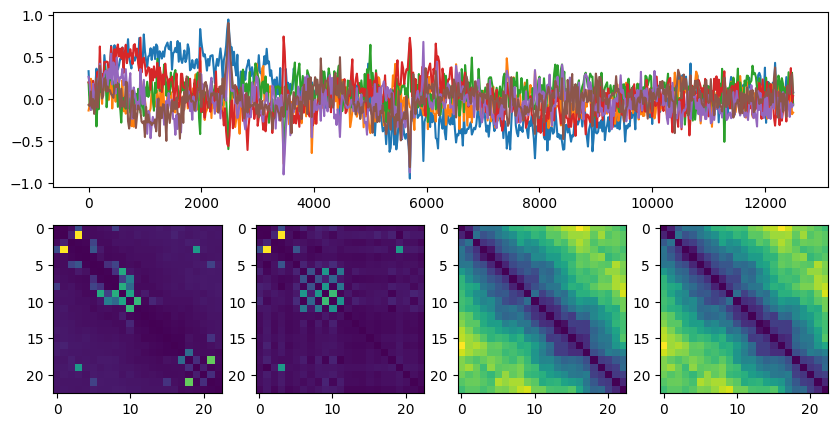

In [12]:
nfft = int(Fe/dfen)

f = np.fft.rfftfreq(nfft, 1/Fe)
d0 = 0.2
bounds = (0.05, 0.6)

C = cogpu.coherence(P = Mems.astype('float32').T, kSel= np.arange(int(nfft//2+1)),
                         Nr = NbMems, NFFT = nfft, B = NbFrames) 
D1 = cal.C2Dfit(    C=C, freq = f, D_init = DVrai, c0=c0)
D1 = np.delete(D1, 18, 0)
D1 = np.delete(D1, 18, 1)
D2 = cal.C2DfitLSq( C=C, freq = f, D_init = DVrai, c0=c0)
D2 = np.delete(D2, 18, 0)
D2 = np.delete(D2, 18, 1)
D1d = cal.DenoiseD(D1,Ndim=3)
D2d = cal.DenoiseD(D2,Ndim=3)
for n in range(D1d.shape[1]):
    for m in range(n+1,D1d.shape[0]):
        D1d[n,m]=D1d[m,n]
        D2d[n,m]=D2d[m,n]
        
fig = plt.figure(figsize=(10,5))
axC = fig.add_subplot(211)
plt.plot(f[::2],np.real(C[::2,1,::4]))
axD1 = fig.add_subplot(245)
plt.imshow(D1)
axD1d = fig.add_subplot(246)
plt.imshow(D1d)
axD2 = fig.add_subplot(247)
plt.imshow(D2)
axD2d = fig.add_subplot(248)
plt.imshow(D2d)

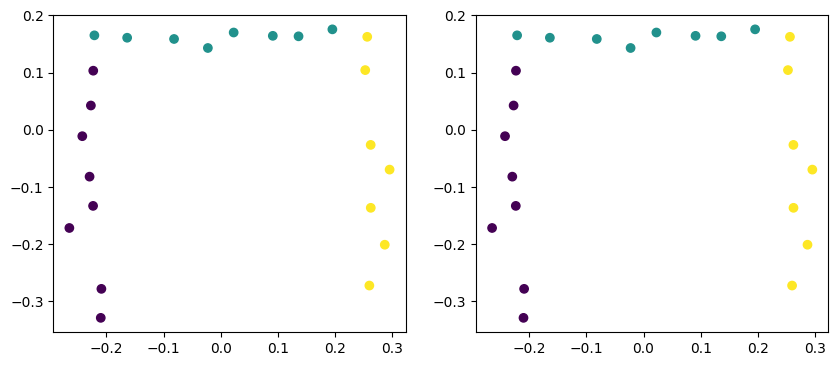

In [15]:
dm = 0.06
F0x = np.array(np.zeros(8) - 4)*dm
F0y = np.array(np.arange(8) - 4)*dm
F1x = np.array(np.arange(8) - 4)*dm
F1y = np.array(4 - np.zeros(8))*dm
F2x = np.array(np.zeros(8) + 4)*dm
F2y = np.array(4 - np.arange(8))*dm

Rmx = np.array([list(F0x)+list(F1x)+list(F2x)]).T
Rmy = np.array([list(F0y)+list(F1y)+list(F2y)]).T
Rmz = np.zeros_like(Rmy)

Rm3 = np.array([Rmx, Rmy, Rmz]).T.squeeze()
Rm2 = np.array([Rmx, Rmy]).T.squeeze()
Rm2 = np.delete(Rm2, 18, 0)
Rm3 = np.delete(Rm3, 18, 0)
# outlier-aware case
lbda = 0.7
solver2 = RMDS(D1)
solver2.d = 2
solver2.Run(lbda = lbda, Xinit = Rm2, EpsLim=1e-12, itmax=200000)
rmds2D1 = solver2.X[-1,...]

solver2 = RMDS(D1d)
solver2.d = 2
solver2.Run(lbda = lbda, Xinit = Rm2, EpsLim=1e-12, itmax=200000)
rmds2D1d = solver2.X[-1,...]

solver2 = RMDS(D2)
solver2.d = 2
solver2.Run(lbda = lbda, Xinit = Rm2, EpsLim=1e-12, itmax=200000)
rmds2D2 = solver2.X[-1,...]

solver2 = RMDS(D2d)
solver2.d = 2
solver2.Run(lbda = lbda, Xinit = Rm2, EpsLim=1e-12, itmax=200000)
rmds2D2d = solver2.X[-1,...]

Fd = np.delete(F,18)
fig = plt.figure(figsize=(10,5))
# axD1 = fig.add_subplot(141)
# axD1.scatter(rmds2D1[:,0],rmds2D1[:,1], c=Fd)
# axD1.set_aspect('equal')
# axD1d = fig.add_subplot(142)
# axD1d.scatter(rmds2D1d[:,0],rmds2D1d[:,1],c=Fd)
# axD1d.set_aspect('equal')
axD2 = fig.add_subplot(121)
axD2.scatter(rmds2D2[:,0],rmds2D2[:,1],c=Fd)
axD2.set_aspect('equal')
axD2d = fig.add_subplot(122)
axD2d.scatter(rmds2D2d[:,0],rmds2D2d[:,1],c=Fd)
axD2d.set_aspect('equal')

In [16]:

# xmin, ymin, zmin = np.min(np.vstack((x0, xc)), 0)
# xmax, ymax, zmax = np.max(np.vstack((x0, xc)), 0)

fig1 = go.Figure()
# fig1.add_trace(go.Scatter3d(name = 'Xm_approx', x = x0[:,0], y = x0[:,1], z = x0[:,2], mode = 'markers',
#                            marker = dict(line_width=1,symbol= ('diamond'), size=5,opacity = 0.25, color = F[MSelect])))
fig1.add_trace(go.Scatter(name = 'Xm2_RMDS',x = rmds2D2[:,0], y = rmds2D2[:,1], mode = 'markers', 
                           marker = dict(line_width=1, size=15, opacity = 1, color = F)))

# fig1.add_trace(go.Scatter(name = 'Xm3_RMDS',x = rmds2D2[:,0], y = rmds2D2[:,1], mode = 'markers', 
#                          marker = dict(line_width=1, size=5, opacity = 1, color = F+3)))


# fig1.update_layout(scene = dict(xaxis = dict(nticks=5, range=[xmin, xmax]),
#                                yaxis = dict(nticks=5, range=[ymin, ymax]),
#                                zaxis = dict(nticks=5, range=[zmin, zmax]))) 
fig1.update_layout(scene_aspectmode='cube',width=500, height = 500)
fig1.update_layout(title="Geometric Calibration using RMDS (Diffuse field)")    
fig1.update_layout()
fig1.show()

In [ ]:
Cov = np.load('pcov.npy')

In [ ]:
a=plt.plot(np.mean(Cov,1))